In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Getting the closest embedded charts

In [2]:
# open biomed_clip
biomedCLIP = pd.read_parquet('embeddings/biomedclip_embeddings.parquet')
biomedCLIP.head()

,image,top_label,clip_embeddings
0,screenshots/heatmap_sw_1_2_s_1_0.png,heatmap,"[0.022331731, 0.007818277, -0.16542432, 0.0080..."
1,screenshots/two_by_two_p_4_m_10_sw_0_7_s_1_2.png,genomics visualization,"[0.019216416, 0.03744839, -0.12684523, -0.0058..."
2,screenshots/multiple_view_p_2_m_12_sw_0_7_s_0_...,circular genomic visualization,"[-0.0016217616, -0.051115554, -0.07445832, -0...."
3,screenshots/two_by_two_uneven_w_m_20_sw_0_7_s_...,genomics visualization,"[-0.0015807527, 0.038776863, -0.13082261, 0.05..."
4,screenshots/multiple_view_p_1_m_8_sw_1_2_s_1_0...,circular genomic visualization,"[-0.002367256, -0.0421267, -0.04676023, -0.033..."


In [5]:
import open_clip
import torch

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

In [11]:
query_image = Image.open("hic-matrix.png")
image = preprocess_val(query_image).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)

query_embedding = image_features.cpu().numpy().flatten()

/Users/etowah/projects/forks/spec-image-embeddings/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


The 5 most similar images using biomedCLIP are the following:


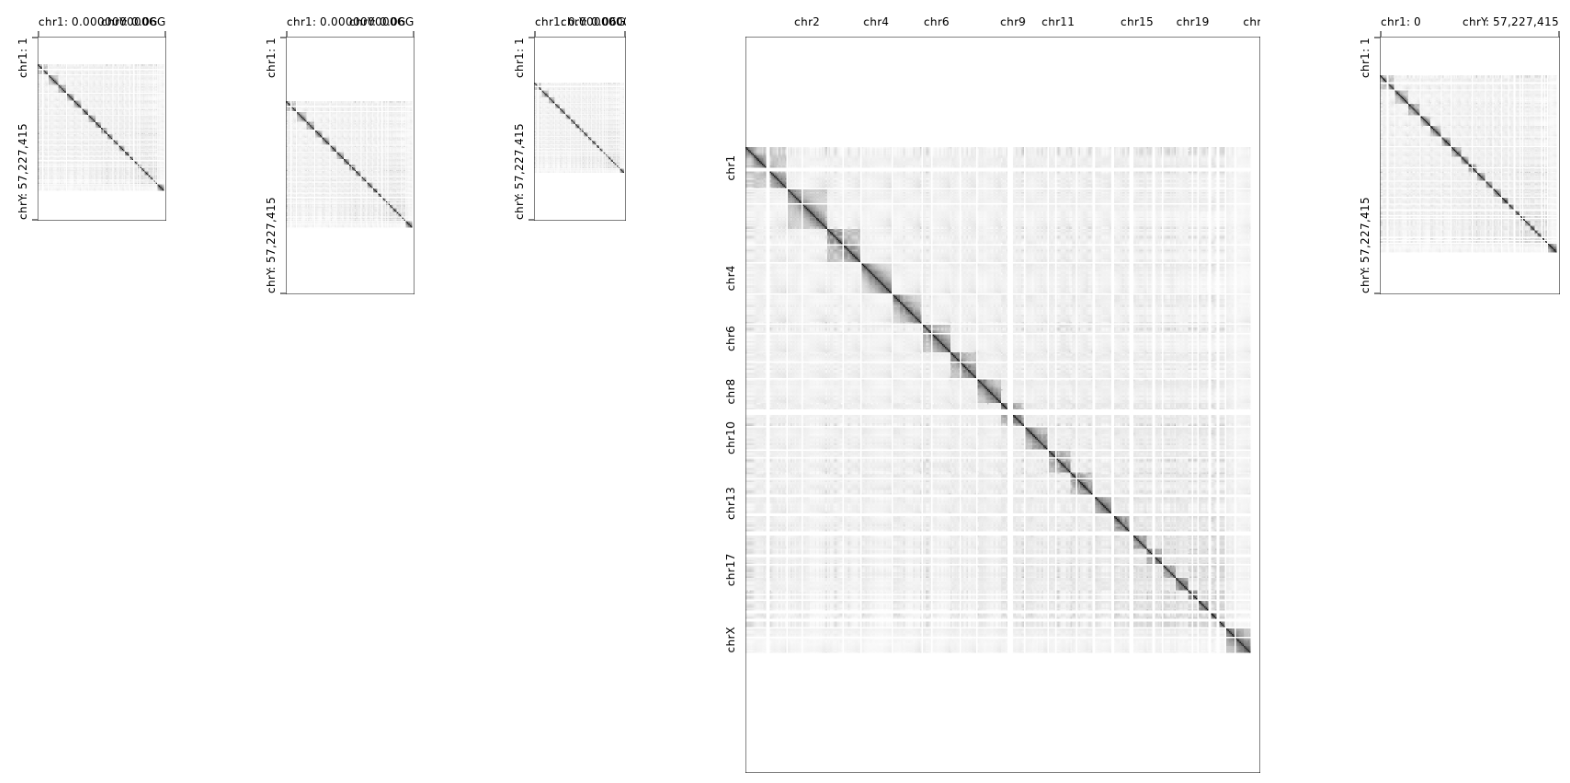

In [12]:

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def most_similar(embedding, embeddings, top_n=5):
    similarities = np.array([cosine_similarity(embedding, emb) for emb in embeddings])
    return np.argsort(similarities)[::-1][:top_n]

def display_images(img_paths):
    # concatenate images horizontally and display
    images = [Image.open(img_path) for img_path in img_paths]
    padding = 100
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths) + padding * (len(images) - 1)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    # Make the background white
    new_im.paste((255, 255, 255), (0, 0, total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0] + padding
    # open image with matplotlib
    plt.figure(figsize=(20, 20))
    plt.imshow(new_im)
    plt.axis('off')

biomedCLIP_embeddings = np.array(biomedCLIP['clip_embeddings'].to_list())
top_5 = most_similar(query_embedding, biomedCLIP_embeddings, top_n=5)
img_paths = biomedCLIP.loc[top_5]['image'].to_list()
print('The 5 most similar images using biomedCLIP are the following:')
display_images(img_paths)
